<a href="https://colab.research.google.com/github/kamilo116/KNN/blob/master/KNN_Avg_No_Relu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import pandas as pd
import os
import csv
import sys
from random import shuffle
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow
%matplotlib inline
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.transforms as transforms
import timeit

np.random.seed(4) 
torch.manual_seed(4) 
torch.cuda.manual_seed(4)

In [2]:
! git clone https://github.com/wang-chen/kervolution.git 

sys.path.append("kervolution/")
from kervolution import Kerv2d


fatal: destination path 'kervolution' already exists and is not an empty directory.


In [0]:
LIMIT_IMAGES_NUM = 500
train_test_split_size = 0.2
image_resize = (100, 100)
batch_size = 64
num_workers = 0

in_channels = 3
out_channels_0 = 8
out_channels_1 = 16
out_channels_2 = 32
out_channels_3 = 64
out_channels_4 = 128

kernel_size = 3
padding_1 = 1
num_epochs = 80

learning_rate = 0.0001
weight_decay = 0

MALIGNANT_DATASET = '/content/drive/My Drive/Colab_data/malignant/malignant/'
BENIGN_DATASET = '/content/drive/My Drive/Colab_data/benign/benign/'
DATA_FOLDER = '/content/drive/My Drive/Colab_data/'
model_backup_path = os.path.join(DATA_FOLDER, 'backup_model') 

In [4]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
benign_file_list = sorted(os.listdir(BENIGN_DATASET))
malignant_file_list = sorted(os.listdir(MALIGNANT_DATASET))
shuffle(benign_file_list)
shuffle(malignant_file_list)
benign_file_list = benign_file_list[:LIMIT_IMAGES_NUM]
malignant_file_list = malignant_file_list[:LIMIT_IMAGES_NUM]

print(f"Number of benign {len(benign_file_list)} images")
print(f"Number of malignant {len(malignant_file_list)} images")

data_transforms = transforms.Compose([
    transforms.Resize(image_resize),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])



Number of benign 500 images
Number of malignant 500 images


In [0]:
benign_dict = {filename: 0 for filename in benign_file_list}
malignant_dict = {filename: 1 for filename in malignant_file_list}
img_class_dict = {**benign_dict , **malignant_dict}
labeled_data = pd.Series(img_class_dict)

In [0]:
class IsicDataset(Dataset):
    def __init__(self, data_folder, labeled_data, 
                 transform=transforms.Compose([transforms.ToTensor()])):
        self.labeled_data = labeled_data
        self.transform = transform
        self.data_folder = data_folder
        
        
    def __len__(self):
        return len(self.labeled_data)

    def __getitem__(self, index):
        label = self.labeled_data[index]
        if label == 0:
          image = Image.open(os.path.join(self.data_folder, "benign", "benign", index ))
        else:
          image = Image.open(os.path.join(self.data_folder, "malignant", "malignant", index ))
        image = self.transform(image)
        return image, label

    @property
    def labels(self):
      return self.labeled_data


In [8]:
 
dataset = IsicDataset(DATA_FOLDER, labeled_data, transform=data_transforms)
print(dataset.labels)

X_train, X_test = train_test_split(dataset.labels, test_size=train_test_split_size)
print("number of training data: ",len(X_train))
print("number of testing  data: ",len(X_test))

train_sampler = SubsetRandomSampler(list(X_train.index))
valid_sampler = SubsetRandomSampler(list(X_test.index))


train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)



ISIC_0000770.jpeg    0
ISIC_0000437.jpeg    0
ISIC_0002375.jpeg    0
ISIC_0000772.jpeg    0
ISIC_0000128.jpeg    0
                    ..
ISIC_0011874.jpeg    1
ISIC_0010415.jpeg    1
ISIC_0000002.jpeg    1
ISIC_0010631.jpeg    1
ISIC_0013995.jpeg    1
Length: 1000, dtype: int64
number of training data:  800
number of testing  data:  200


In [0]:
avg_loss_list = []
acc_list = []

def train(model, train_loader ,loss_fn, optimizer, num_epochs=1, starting_from_epoch=1):
    total_loss =0

    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()

        for t, (x, y) in enumerate(train_loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            total_loss += loss.data
            
            if (t + 1) % print_every == 0:
                avg_loss = total_loss/print_every
                print('t = %d, avg_loss = %.4f' % (t + 1, avg_loss) )
                avg_loss_list.append(avg_loss)
                total_loss = 0
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        acc = check_accuracy(model_gpu, valid_loader)
        print('acc = %f' %(acc))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_gpu.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, model_backup_path)
            
def check_accuracy(model, loader):
    print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() 
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype))

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    acc_list.append(acc)
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc
    

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)  

In [11]:
gpu_dtype = torch.cuda.FloatTensor

print_every = 1


'''
Kerv2d
kervolution with following options:
kernel_type: [linear, polynomial, gaussian, etc.]
default is convolution:
          kernel_type --> linear,
balance, power, gamma is valid only when the kernel_type is specified
if learnable_kernel = True,  they just be the initial value of learable parameters
if learnable_kernel = False, they are the value of kernel_type's parameter
the parameter [power] cannot be learned due to integer limitation
dilation (int or tuple, optional): Spacing between kernel
elements. Default: 1
groups (int, optional): Number of blocked connections from input
channels to output channels. Default: 1
bias (bool, optional): If ``True``, adds a learnable bias to the output. Default: ``True``
kernel_type (str), Default: 'linear'
learnable_kernel (bool): Learnable kernel parameters.  Default: False 
balance: 0, 1
power: 3, 4, 5
gamma:
'''


model_base = nn.Sequential( 
                nn.Kerv2d(in_channels , out_channels_0, padding=padding_1, dilation=1, groups=1, bias=True, 
                          kernel_type='polynomial', kernel_size=kernel_size, learnable_kernel=True,
                          kernel_regularizer=True, stride=1, balance=1, power=3, gamma=1
                          ),
                           nn.BatchNorm2d(out_channels_0),
                nn.AvgPool2d(2, stride=2),
                nn.Conv2d(out_channels_0 , out_channels_1, padding= padding_1, kernel_size=kernel_size, stride=1), 
                nn.BatchNorm2d(out_channels_1),
                nn.AvgPool2d(2, stride=2),
                nn.Conv2d(out_channels_1 , out_channels_2, padding= padding_1, kernel_size=kernel_size, stride=1), 
                nn.BatchNorm2d(out_channels_2),
                nn.AvgPool2d(2, stride=2),
                nn.Conv2d(out_channels_2 , out_channels_3, padding= padding_1, kernel_size=kernel_size, stride=1),  
                nn.BatchNorm2d(out_channels_3),
                nn.AvgPool2d(2, stride=2),
                nn.Conv2d(out_channels_3 , out_channels_4, padding= padding_1, kernel_size=kernel_size, stride=1),  
                nn.BatchNorm2d(out_channels_4),
                nn.AvgPool2d(2, stride=2),
                nn.Dropout(0.5),
                Flatten(),
                nn.Linear(1152,64),
                nn.Linear(64,2)
            )
model_gpu = model_base.type(gpu_dtype)
print(model_gpu)
loss_fn = nn.modules.loss.CrossEntropyLoss()
optimizer = optim.Adam(model_gpu.parameters(), lr = learning_rate, weight_decay=weight_decay) 

train(model_gpu, train_loader ,loss_fn, optimizer, num_epochs=num_epochs)
check_accuracy(model_gpu, valid_loader)


Sequential(
  (0): Kerv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, 

KeyboardInterrupt: ignored

In [12]:
check_accuracy(model_gpu, valid_loader)

Checking accuracy on test set
Got 145 / 200 correct (72.50)


0.725

In [0]:
def retry_from_backup()
  model_gpu = model_base.type(gpu_dtype)
  print(model_gpu)
  loss_fn = nn.modules.loss.CrossEntropyLoss()
  optimizer = optim.Adam(model_gpu.parameters(), lr = learning_rate, weight_decay=weight_decay) 



  checkpoint = torch.load(model_backup_path)
  model_gpu.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  print("starting from epoch: " + str(epoch))
  print("starting from loss: " + str(loss))
  print(checkpoint['model_state_dict'])
  print(checkpoint['optimizer_state_dict'])

  train(model_gpu, train_loader ,loss_fn, optimizer, num_epochs=num_epochs, starting_from_epoch=epoch)
  check_accuracy(model_gpu, valid_loader)
#retry_from_backup()

Loss:


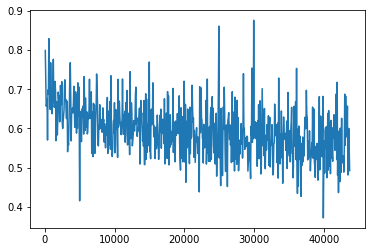

In [13]:
import matplotlib.pyplot as plt

plt.plot([print_every*batch_size*(i+1) for i in range((len(avg_loss_list)))],avg_loss_list)
print("Loss:")
plt.show()

Accurancy:


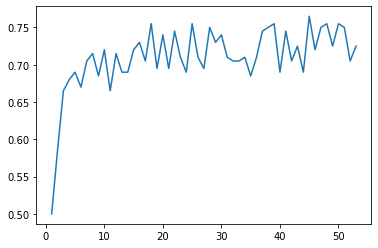

In [14]:
plt.plot([i+1 for i in range((len(acc_list)))],acc_list)
print("Accurancy:")
plt.show()

In [0]:
#%tensorboard --logdir {logs_base_dir}